In [1]:
import pandas as pd
import pickle5 as pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
import plotly.express as px

# _root_path = '/content/drive/MyDrive/PoliticalSentimentAnalysis/'
_root_path = '../'

# load data
with open(_root_path + 'data/tweets.pkl', 'rb') as f:
    tweets_df = pickle.load(f)

# Get all tweets from 2019
tweets_df.sort_values(by='Date', inplace=True)
tweets_df = tweets_df[tweets_df.Date > datetime.datetime(2019,1,1)]

emotions = ['Anger', 'Anticipation', 'Joy', 'Trust', 'Fear','Surprise', 'Sadness', 'Disgust', 'Neutral']

# Rename party for clearer plots and set party color
# tweets_df.Party = tweets_df.Party.apply(lambda p: 'Republican' if p == 'R' else 'Democratic')
party_colors = dict(
    D='tab:blue',
    Democratic='tab:blue',
    R='tab:red',
    Republican='tab:red',
)

# set default params
plt.rcParams["figure.figsize"] = (8, 5)
plt.rc('font', size=12)

emotions = ['Anger', 'Anticipation', 'Joy', 'Trust', 'Fear','Surprise', 'Sadness', 'Disgust']

In [46]:
# Get data per week for emotion and party
df = tweets_df[['Date', 'Party'] + emotions]
df.set_index('Date', inplace=True)
df = df.groupby(['Party', pd.Grouper(freq='D')]).mean()
df = df.stack()
df = df.reset_index()
df.columns = ['Party', 'Date', 'Emotion', 'value']
df = df.pivot_table(values='value', index=['Emotion', 'Party'], columns='Date').loc[emotions]

In [47]:
y = [' - '.join(i) for i in df.index]

fig = go.Figure(data=go.Heatmap(
        z=df.values,
        x=df.columns,
        y=y,
        colorscale='viridis',
        zmax=0.2,
        zmid=0.6,
        zmin=0.,
        ))

fig.update_layout(
    xaxis_nticks=36,
    yaxis_autorange='reversed',
    yaxis_title='Daily Average Emotion Share [in %]',
    font_color='black',
    font_size=11,
    width=1000,
    height=300,
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.update_traces(colorbar_thickness=15)

fig.show()
fig.write_image(_root_path + 'output/figures/emotions/emotion_heatmap_daily.png')
fig.write_html(_root_path + 'output/figures/emotions/emotion_heatmap_daily.html')


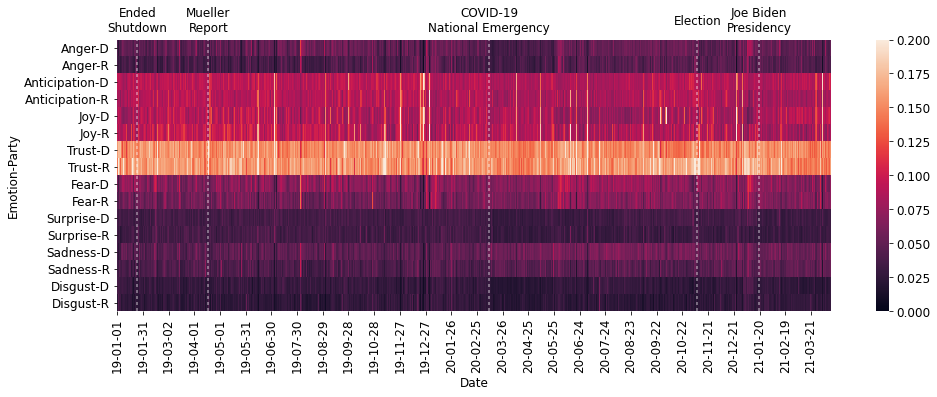

In [145]:
vmin = 0
vmax = 0.2

# plot heatmap
fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(data=df, ax=ax, vmin=vmin, vmax=vmax)

for date, event in (((2019, 1, 25), 'Ended\nShutdown'),
                    ((2019, 4, 18), 'Mueller\nReport'),
                    ((2020, 3, 11), 'COVID-19\nNational Emergency'),
                    ((2020, 11, 9), 'Election'),
                    ((2021, 1, 20), 'Joe Biden\nPresidency'),
                    ):
    date = (datetime.datetime(*date) - datetime.datetime(2019,1,1)).days
    plt.axvline(date, 0, 1, color='white', alpha=0.5, dashes=(2., 2.))
    plt.text(date, -1.1, event, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'), ha='center', va='center')

ax.set_xticklabels(df.columns[::int(ax.get_xticks()[1] - ax.get_xticks()[0])].strftime('%y-%m-%d'))
ax.set_xticks(ax.get_xticks()[::2])
plt.show()


In [40]:
# average values
df = tweets_df[['Party'] + emotions]
df = df.groupby(['Party'])[emotions].mean()
df = df.apply(lambda x: x /df.sum(axis=1))
df = df *100
df = df.stack().to_frame().reset_index()
df.columns = ['Party', 'Emotion', 'Average Percentage']

In [44]:
fig = px.bar(df, y='Party', x='Average Percentage', color='Emotion', barmode = 'stack', text='Average Percentage',
             template='simple_white', orientation='h',
             color_discrete_sequence=px.colors.sequential.Viridis[5:-1] + px.colors.sequential.Viridis_r[6:])

fig.update_layout(
    font_color='black',
    font_size=11,
    width=900,
    height=130,
    margin=dict(l=0, r=0, t=0, b=0),
    legend=dict(orientation="h", y=1.6, title='', xanchor="center", x=0.5),
)
fig.update_traces(texttemplate='%{text:.2f}%')
fig.update_xaxes(range=(0,100), title='Proportion of Emotions in Tweets [in %]')
fig.show()
fig.write_image(_root_path + 'output/figures/emotions/emotion_party_bar.png')
